# ELEC 400M / EECE 571M Assignment 2: Neural networks
(This assignment is a modified version of an assignment used in ECE 421 at the University of Toronto and kindly made available to us by the instructor.)

In this assignment, you will implement a neural network model for multi-class classification. The purpose is to demonstrate an understanding of the basic elements including training of neural network models. Hence, your implementation will be from scratch only using functions from the NumPy library.

The neural network you will be implementing has the following structure:
* 3 layers: 1 input layer, 1 hidden layer with ReLU activation and 1 output layer with Softmax function 􏴣 
* The loss function is the Cross Entropy Loss.
* Training will be done using Gradient Descent with Momentum. 

## Data Set
We again consider the dataset of images of letters in different fonts contained in file notMNIST.npz (which btw is from http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html). This time we consider 10 letters ("A" to "J"), which are all the letters contained in this data set, and we want to classfiy the images according to the letter they display. The figure below shows 30 randomly selected image samples for the letters.

![](sample_images_2.eps)


You will apply the function `loadData` given below to load the data set, which includes 18720 images and their labels, which we also refer to as targets. This script organizes the data set into training, validation and test sets. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def loadData():
    with np.load('notMNIST.npz') as data:
        Data, Target = data['images'], data['labels']
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx]/255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:15000], Target[:15000]
        validData, validTarget = Data[15000:16000], Target[15000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
       
    return trainData, validData, testData, trainTarget, validTarget, testTarget

## Data preprocessing [5 points]

Input data: The classification should be based on the $d=28\times 28=784$ intensity values in an image (as for Assignment 1).

Output data: Since you will be performing multi-class classification, the labels will be converted into a one-hot encoding format. 

Please first briefly explain the meaning of one-hot encoding and why it is used (instead of keeping the numerical label values provided by the data set). State an example for a one-hot encoded label for the data set considered in this assignment.

**Solution:**

One-hot encoding is a way of encoding or representing labels or other categorical data. For instance, if there are 'n' classes that have unique labels, they may be numerically labeled using numbers from 0 to (n-1). Alternatively, they may also be one-hot encoded using a label that is n-bits wide and has the nth bit (coresponding to the nth numerical label) set to 1.

For most classification problems, machine learning algorithms may misinterpret numerical data and infer some sort of hierarchy or relationship amongst the data that is not necessarily relevant to the problem at hand. This can ultimately lead the algorithm to learn a false hypothesis. One-hot encoding is a way of pre-processing the labels to remove any such hierarchical relationship so that the machine learning algorithm does not infer anything that is otherwise not useful to the task it is trying to accomplish.

__Example of One-Hot-Encoding__

Consider a few numerical labels from the training data-set (numbered from 0-9), their corresponding one-hot encoded values are represented alongside.

| Categorical Data (From Dataset) | Numerical Label | One-Hot Encoded Label |
|:-------------------------------:|:---------------:|:---------------------:|
|                A                |        0        | [1;0;0;0;0;0;0;0;0;0] |
|                B                |        1        | [0;1;0;0;0;0;0;0;0;0] |
|                H                |        8        | [0;0;0;0;0;0;0;0;1;0] |
|                E                |        5        | [0;0;0;0;0;1;0;0;0;0] |

Now implement a function that one-hot encodes the labels (or targets) for the training, validation and test sets. 

In [15]:
def convertOneHot(trainTarget, validTarget, testTarget):
    trainTargetOneHot = np.zeros([trainTarget.shape[0],10])
    trainTargetOneHot[np.arange(trainTarget.size),trainTarget]=1
    
    validTargetOneHot = np.zeros([validTarget.shape[0],10])
    validTargetOneHot[np.arange(validTarget.size),validTarget] = 1
    
    testTargetOneHot = np.zeros([testTarget.shape[0],10])
    testTargetOneHot[np.arange(testTarget.size),testTarget]=1
    
    return trainTargetOneHot, validTargetOneHot, testTargetOneHot

## Structure of the network [2 points]

Sketch the structure of the network to classify the letters from the data set. Identify the dimensions of the network layers, include the activation functions, and do not forget the bias nodes. (You may sketch this by hand and upload a photo of your sketch.)

**Solution:**

*Note: A scaled down version of the actual network has been sketched for the sake of space and clarity.*

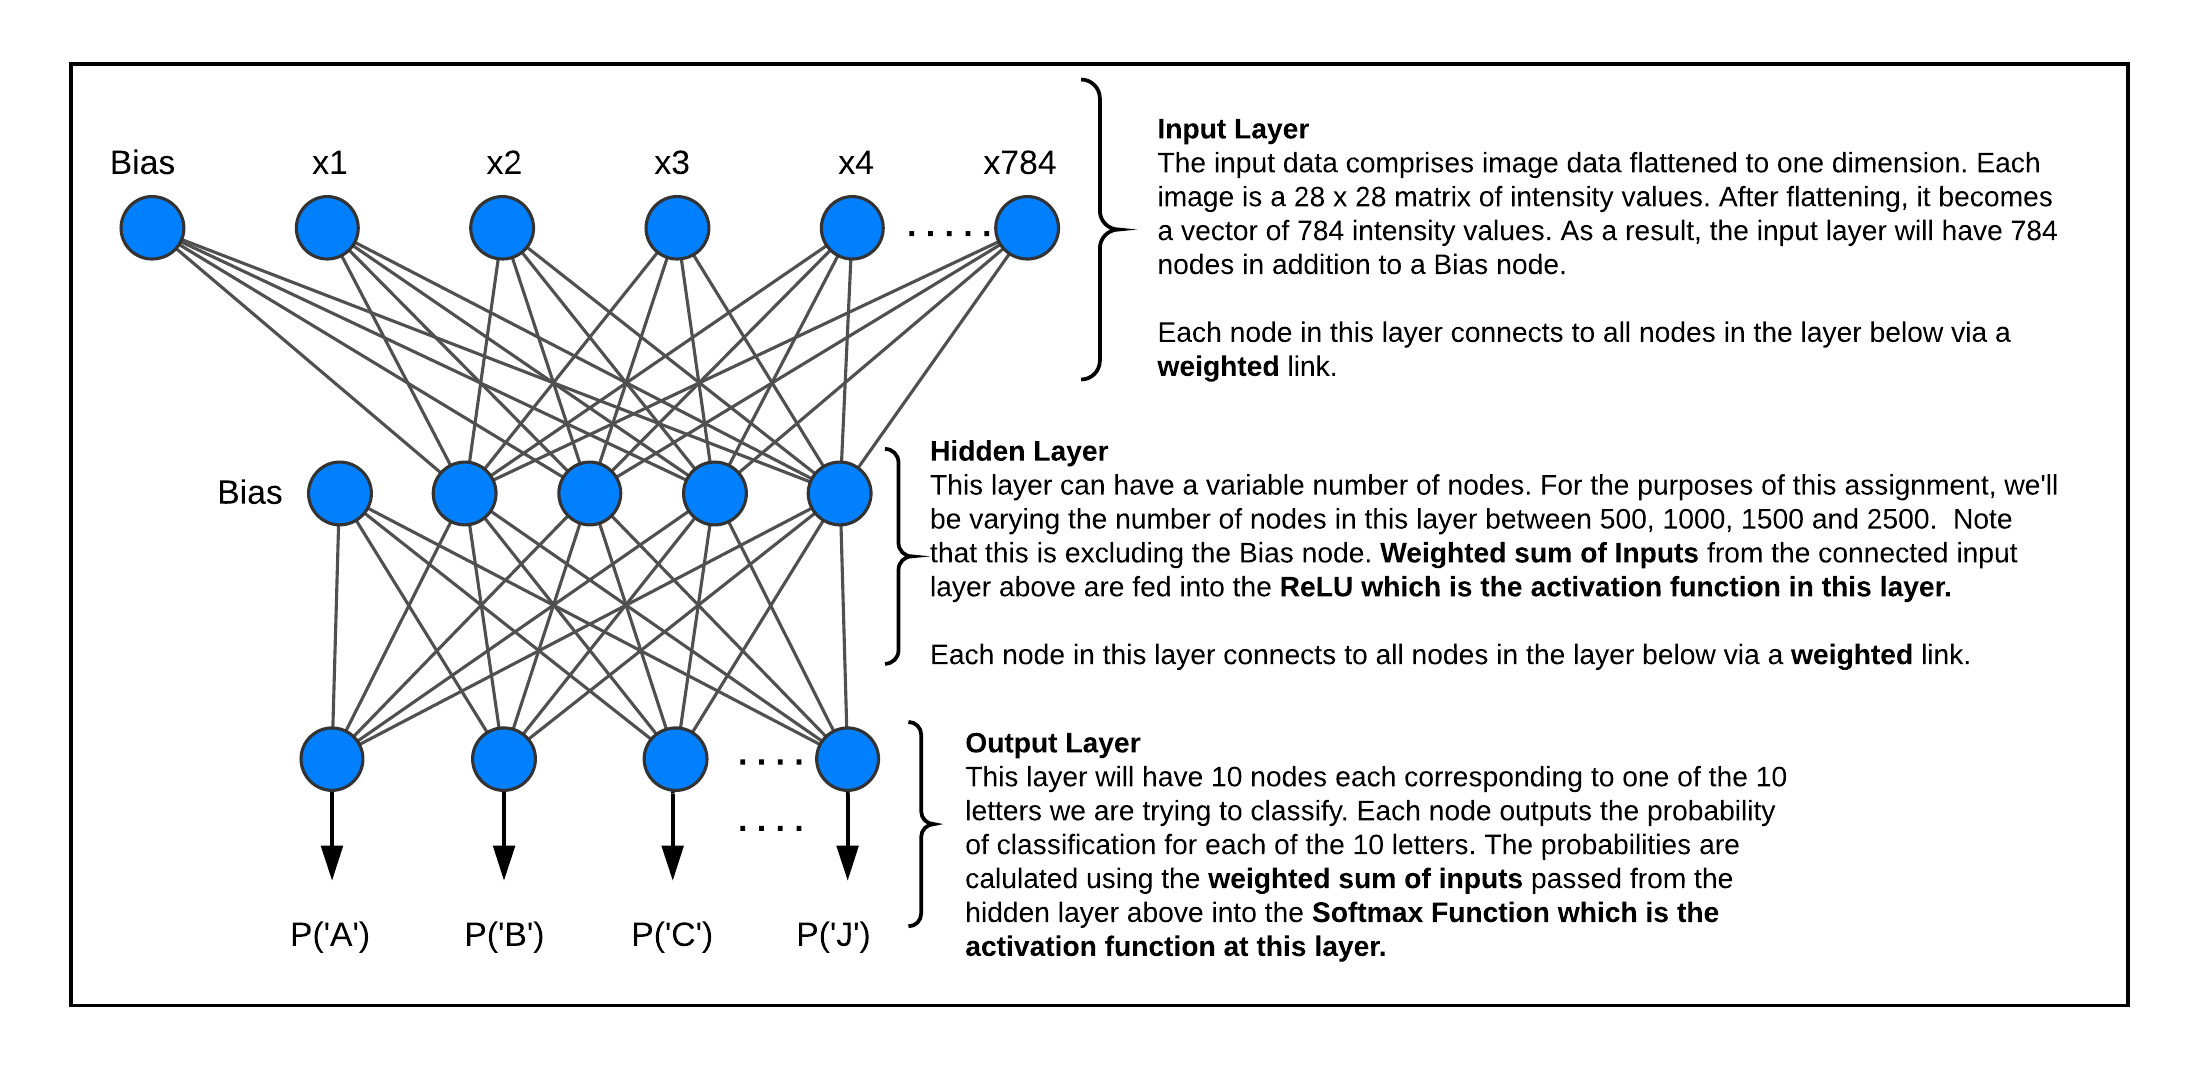

The activation function in the hidden layer is the ReLU    : $\mathrm{ReLU}(x)=\max(0,x).$

The activation function in the output layer is the Softmax : $ P_j = [\sigma(\mathbf{z})]_j = \frac{\mathrm{e}^{z_j}}{\sum\limits_{k=1}^{10}\mathrm{e}^{z_{10}}}$ where $j=1,2,\ldots, 10$,  for $10$ classes.

## Helper functions [6 points]
To give the implementation of the network some structure, you will first implement five helper functions. 

Use Numpy arrays for your implementations, and organize data in vectors and matrices as appropriate for compact programming.

1. `relu`: This function will accept one argument and return the ReLU activation: 
    $$\mathrm{ReLU}(x)=\max(0,x).$$
    
2. `softmax`: This function will accept one argument and return the softmax activations:
    $$ [\sigma(\mathbf{z})]_j = \frac{\mathrm{e}^{z_j}}{\sum\limits_{k=1}^K\mathrm{e}^{z_k}},$$ $j=1,2,\ldots, K$,  for $K$ classes.

3. `computeLayer`: This function will accept two arguments, the input vector $\mathbf{x}$ for a layer and the weight matrix $\mathbf{W}$, and return a vector $\mathbf{s}=\mathbf{W}^T\mathbf{x}$, i.e., the input to the activation function of the layer (the notation for variables from the textbook is used). Don't forget to account for the bias term (which can be included in an augmented vector $\mathbf{x}$ as in the textbook).

4. `CE`: This function will accept two arguments, the one-hot encoded labels $\mathbf{y}_n$ and the inputs $\mathbf{s}_n$ to the softmax function, $n=1,2,\ldots N$. It will return the cross entropy loss
$$\mathrm{E}_{\mathrm{in}}=-\frac{1}{N}\sum\limits_{n=1}^N\sum\limits_{k=1}^Ky_{n,k}\log([\sigma(\mathbf{s}_n)]_k)$$

5. `gradCE`: This function will accept two arguments, the labels and the inputs to the softmax function. It will return the gradient of the cross entropy loss with respect to the inputs (i.e., it returns the sensivity vector for the output layer as introduced in the textbook). 

First state the analytical expression for the gradient used in `gradCE` and then implement the five helper functions.

**Solution:**

The analytical expression for the gradient used in gradCE is given by,

$$\delta^{\left(L\right)}_{n}=\frac{\partial e_{n}}{\partial S^{L}_{n}}=\sigma\left(S^{L}_{n}\right)-y_{n}$$

Where $\sigma$ refers to the softmax function and $n$ is associated with the $n^{th}$ input. That is, $n \in [0,N]$ 

In [16]:
def relu(x):
    return np.maximum(0,x)

In [17]:
def softmax(x):
    maxes = np.amax(x,axis=0)
    maxes = maxes.reshape(1,maxes.shape[0])
    x = x - maxes
    op = np.exp(x)/sum(np.exp(x))
    return op

In [18]:
def computeLayer(x,W):
    return np.matmul(W.T,x)

In [19]:
def CE(target, prediction):
    return (-1/target.shape[1])*(np.sum(np.multiply(target,np.log(1E-15+softmax(prediction)))))

In [20]:
def gradCE(target, prediction):
    return softmax(prediction)-target

## Backpropagation [2 points]

The training of the network will be done via backpropagation. First derive the following gradients:
1. $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{o}}}$, where $\mathbf{W}^{\mathrm{o}}$ is the weight matrix of the output layer.

2. $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{h}}}$, where $\mathbf{W}^{\mathrm{h}}$ is the weight matrix of the hidden layer.

Write the results using the steps and notation used in the textbook.

**Solution:**

We know that,

$$E_{in}=\frac{1}{N}\sum_{n=1}^{N}e_{n}$$

$$\frac{\partial E_{in}}{\partial W^{\left(l\right)}}=\frac{1}{N}\sum_{n=1}^{N}\frac{\partial e_{n}}{\partial W^{\left(l\right)}}$$

where,

$$\frac{\partial e_{n}}{\partial W^{\left(l\right)}}=\frac{\partial S_n^{\left(l\right)}}{\partial W^{\left(l\right)}} . \frac{\partial e_n}{\partial S_n^{\left(l\right)}}=\frac{\partial \left( \left(W^{\left(l\right)}\right)^T.x_n^{l-1}\right)}{\partial W^{\left(l\right)}}.\frac{\partial e_n}{\partial S_n^{\left(l\right)}}$$

thus,

$$\frac{\partial e_{n}}{\partial W^{\left(l\right)}}=x_n^{l-1}.\frac{\partial e_n}{\partial S_n^{\left(l\right)}}=x_n^{l-1}\left(\delta_n^{l}\right)^T\ \ -----\ Equation\ 1$$

Where $\frac{\partial e_n}{\partial S_n^{\left(l\right)}}=\delta_n^{l}$ is the sensitivity vector at layer $l$. The gradients for each layer is given by,

**1. $\frac{\partial E_{in}}{\partial W^{O}}$ where $W^{O}$ is the weight matrix of the output layer.**

$$\frac{\partial E_{in}}{\partial W^{O}}=\frac{1}{N}\sum_{n=1}^{N}\frac{\partial e_{n}}{\partial W^{O}}=\frac{1}{N}\sum_{n=1}^{N}\left(x_n^{O-1}\left(\delta_n^{O}\right)^T\right)$$

The sensitivity at the output layer, $\delta_n^{O}$ is given by,

$$\delta_n^{O}=\frac{\partial e_n}{\partial S_n^{\left(O\right)}}$$

where, $e_n=-\sum_jy_{n,j}\log{[\sigma(\mathbf{S}_n)]_j}$ and $\sigma(\mathbf{S}_n)=\frac{e^{S_n}}{\sum_{k=1}^Ne^{\left(S_n\right)_k}}$ where $\sigma$ is the activation (softmax) at the output layer. 

Applying the analytical expression for gradCE from the previous section,

$$\delta_n^{O}=\frac{\partial e_n}{\partial S_n^{\left(O\right)}}=\frac{\partial e_{n}}{\partial S^{O}_{n}}=\sigma\left(S^{O}_{n}\right)-y_{n}\ \ -----\ Equation\ 1.A$$

Applying $Equation\ 1.A$ in $Equation\ 1$

$$\frac{\partial E_{in}}{\partial W^{O}}=\frac{1}{N}\sum_{n=1}^{N}\left(x_n^{O-1}\left(\sigma\left(S^{O}_{n}\right)-y_{n}\right)^T\right)$$

**2. $\frac{\partial E_{in}}{\partial W^{h}}$ where $W^{h}$ is the weight matrix of the hidden layer.**

$$\frac{\partial E_{in}}{\partial W^{h}}=\frac{1}{N}\sum_{n=1}^{N}\frac{\partial e_{n}}{\partial W^{h}}=\frac{1}{N}\sum_{n=1}^{N}\left(x_n^{h-1}\left(\delta_n^{h}\right)^T\right)\ \ -----\ Equation\ 2.A$$

The sensitivity at the hidden layer, $\delta_n^{h}$ is given by,

$$\delta_n^{h}=\frac{\partial e_n}{\partial S_n^{\left(h\right)}}=\frac{\partial e_n}{\partial x_n^{h}}.\frac{\partial x_n^{h}}{\partial S_n^{h}}=\frac{\partial e_n}{\partial x_n^{h}}.\theta'\left(S_n^{h}\right)\ \ -----\ Equation\ 2.B$$

Where $x_n^{h}=\theta\left(S_n^{h}\right)$ and $\theta$ is the activation function (ReLU) at the hidden layer. 

Finally, 

$$\frac{\partial e_n}{\partial x_n^{h}}=\left[W^O\delta^O\right]_1^{d^{\left(h\right)}}$$

Applying this to $Equation\ 2.B$,

$$\delta_n^{h}=\theta'\left(S_n^{h}\right)\otimes\left[W^O\delta_n^O\right]_1^{d^{\left(h\right)}}\ \ -----\ Equation\ 2.C$$

Where $\otimes$ denotes element-wise multiplication.

Applying $Equation\ 2.C$ in $Equation\ 2.A$, we finally get

$$\frac{\partial E_{in}}{\partial W^{h}}=\frac{1}{N}\sum_{n=1}^{N}x_n^{h-1}\left[\theta'\left(S_n^{h}\right)\otimes\left[W^O\delta_n^O\right]_1^{d^{\left(h\right)}}\right]^T$$

## Network training [8 points]

Implement a function to train the network. The function uses the helper functions from above. The optimization technique for backpropagation will be Gradient Descent with Momentum:
$$\mathbf{V}(t)=\alpha \mathbf{V}(t-1)-\eta\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}(t)}$$
and 
$$\mathbf{W}(t+1)=\mathbf{W}(t)+\mathbf{V}(t),$$
where $\eta$ is the learning rate and $\alpha$ is the momentum hyperparameter.

The training function accepts the following inputs:  training data (features), training labels, weight matrix of the hidden layer, weight matrix of the output layer, number of iterations, parameters $\eta$ and $\alpha$, validation data, validation labels, test data, test labels. The validation and test inputs are initialized to "None" and need not be passed on. You will also need to initialize the velocity matrices $\mathbf{V}$ for both hidden layer and output layer weights to small values, e.g. $10^{-5}%$.

The function outputs the updated weight matrices, the losses and classification accuracies for the training data, and if validation and test inputs were provided, then it also outputs the classification accuracies for the validation and test data.

In [22]:
# Utility Functions
    
# A. Easy ForwardProp
def forwardProp(inputData,targetLabel,weightHidd,weightOp):
    # 1. Hidden Layer
    # Add Bias and Multiply with Weights to get S(1)
    sToHidd = computeLayer((np.append(np.ones((inputData.shape[0],1)),inputData,axis=1)).T,weightHidd)
    # Calculate Activation to get X(1)
    xToOp = relu(sToHidd)
        
    # 2. Output Layer
    # Add Bias and Multiply with Weights to get S(L)
    sToOp = computeLayer((np.append(np.ones((1,xToOp.shape[1])),xToOp,axis=0)),weightOp)
    # Calculate Activation to get h(x)
    fpassResult = softmax(sToOp)
    # Calculate Loss
    fpassLoss  = CE(targetLabel.T,sToOp)
        
    return fpassResult, fpassLoss
    
# B. Easy Classification Accuracies
def classAccuracy(fpassResult,targetLabel):
    # Fpass Classification
    fpassClass = np.argmax(fpassResult,axis=0)
    # True Classification
    trueClass = np.argmax(targetLabel,axis=0)
    
    return np.sum(fpassClass==trueClass)/targetLabel.shape[1]

def trainNN(trainingData, trainingTarget, weightHidd, weightOp, numIter, eta, alpha, validationData, validationTarget, testData, testTarget):
    # eta   --> Learning Rate
    # alpha --> Momentum
    
    # Grab NN Dimensions
    numHiddenUnits = weightHidd.shape[1]
    numOpUnits = weightOp.shape[1]
    numIpVectors = trainingData.shape[0]
    numInputs = trainingData.shape[1]
    
    # Initialize Matrices
    velocityHidd = 1E-5 * (np.ones([weightHidd.shape[0],weightHidd.shape[1]]))
    velocityOp = 1E-5 * (np.ones([weightOp.shape[0],weightOp.shape[1]]))
    sToHidd = np.zeros([trainingData.shape[0],numHiddenUnits])
    sToOp = np.zeros([trainingData.shape[0],numOpUnits])
    
    lossesTrain = np.zeros([numIter,1])
    lossesValid = np.zeros([numIter,1])
    lossesTest = np.zeros([numIter,1])
    
    accuracyTrain = np.zeros([numIter,1])
    accuracyValid = np.zeros([numIter,1])
    accuracyTest = np.zeros([numIter,1])

    i = 1
    while (i != numIter+1):
        
        # 1. Hidden Layer
        # Add Bias and Multiply with Weights to get S(1)
        sToHidd = computeLayer((np.append(np.ones((trainingData.shape[0],1)),trainingData,axis=1)).T,weightHidd)
        # Calculate Activation to get X(1)
        xToOp = relu(sToHidd)
        
        # 2. Output Layer
        # Add Bias and Multiply with Weights to get S(L)
        sToOp = computeLayer((np.append(np.ones((1,xToOp.shape[1])),xToOp,axis=0)),weightOp)
        # Calculate Activation to get h(x)
        hx = softmax(sToOp)
        # Calculate Loss
        lossesTrain[i-1,0] = CE(trainingTarget.T,sToOp)
        
        # Back Propagation
        
        # Part 1 : At OP
        # 1. Grad w.r.t weightOp
        dEdWL = (1/1)*(np.matmul((np.append(np.ones((1,xToOp.shape[1])),xToOp,axis=0)),gradCE(trainingTarget.T,sToOp).T))
        # 2. Velocity OP
        velocityOp = (alpha*velocityOp)-(eta*dEdWL)
        # 3. weightOp Update
        weightOp = weightOp + velocityOp
        
        # Part 2 : At Hidden
        # 1. Grad w.r.t weightHidd
        dedxl = (np.matmul(weightOp[1:,:],gradCE(trainingTarget.T,sToOp)))
        derRelu = (sToHidd>0).astype(int) # Derivative of ReLU
        temp = np.multiply((derRelu),(dedxl)) # [n x numberHiddenNeuron]
        dEdWl = (1/1)*(np.matmul((np.append(np.ones((trainingData.shape[0],1)),trainingData,axis=1)).T,temp.T))
        # 2. Velocity Hidden
        velocityHidd = (alpha*velocityHidd)-(eta*dEdWl)
        # 3. weightHidd Update
        weightHidd = weightHidd + velocityHidd
        
        # Report Accuracies and Losses
        
        # 1. Training Accuracy
        accuracyTrain[i-1,0] = classAccuracy(hx,trainingTarget.T)
        
        # 2. Validation Accuracy
        fpassResValid, lossesValid[i-1,0] = forwardProp(validationData,validationTarget,weightHidd,weightOp)
        accuracyValid[i-1,0] = classAccuracy(fpassResValid,validationTarget.T)
        
        # 3. Testing Accuracy
        fpassResTest, lossesTest[i-1,0] = forwardProp(testData,testTarget,weightHidd,weightOp)
        accuracyTest[i-1,0] = classAccuracy(fpassResTest,testTarget.T)
        
        # Increment Index
        i = i + 1
    return weightHidd, weightOp, lossesTrain, lossesValid, lossesTest, accuracyTrain, accuracyValid, accuracyTest


## Network test [4 points]

Write a script that constructs the neural network.

Initialize your weight matrices by drawing the elements i.i.d. at random from a zero-mean Gaussian distribution with variance equal to $$\sigma_w^2=\frac{2}{\mbox{# of input nodes + # of output nodes}}$$ (Xavier normalization http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 

Build a network with 1000 hidden units and train it for 200 epochs using $\alpha=0.9$ and $\eta=10^{-5}$. Plot the training, validation and testing accuracy curves. State the training, validation and testing accuracies after training. Show the plot and the accuracies in the next markdown cell.

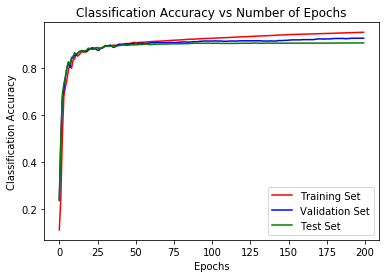

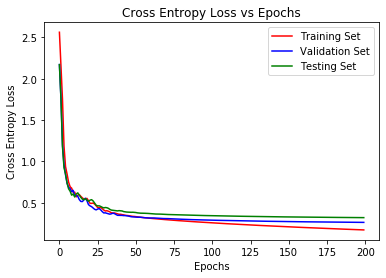

In [23]:
# Load Data
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

trainData = trainData.reshape(trainData.shape[0],-1)
validData = validData.reshape(validData.shape[0],-1)
testData = testData.reshape(testData.shape[0],-1)

trainTargetOneHot, validTargetOneHot, testTargetOneHot = convertOneHot(trainTarget, validTarget, testTarget)

alpha = 0.9                 # Momentum
eta = 0.6*(1e-05)                  # Learning Rate
numIter = 200               # Epochs
numHiddenNeurons = 1000       # Number of Hidden Layer Neurons
numInputNodes = 784         # Excluding Bias
numOpNodes = 10             # 10 Classes
centre = 0                  # Mean of Distribution to Draw Weights

# Weight Matrix Initialization

# Function To Generate Standard Deviation for Xavier Init
def standDevDistr(ipNodes,opNodes):
    variance = 2/(ipNodes+opNodes)
    return np.sqrt(variance)

def constructAndTrainNN(alpha,eta,numIter,numHiddenNeurons,numInputNodes,numOpNodes,centre,trainData,trainTargetOneHot,validData,validTargetOneHot,testData,testTargetOneHot):
    standDevHidd = standDevDistr(numInputNodes,numHiddenNeurons)
    standDevOp = standDevDistr(numHiddenNeurons,numOpNodes)

    weightHiddenLayer = np.random.normal(loc=centre,scale=standDevHidd,size=(numInputNodes+1,numHiddenNeurons))
    #weightHiddenLayer = np.zeros([numInputNodes+1,numHiddenNeurons])
    weightOpLayer = np.random.normal(loc=centre,scale=standDevOp,size=(numHiddenNeurons+1,numOpNodes))
    #weightOpLayer = np.zeros([numHiddenNeurons+1,numOpNodes])

    wHid, wOp, ltrain, lvalid, ltest, atrain, avalid, atest = trainNN(trainData, trainTargetOneHot, weightHiddenLayer, weightOpLayer,numIter,eta,alpha,validData,validTargetOneHot,testData,testTargetOneHot)
    
    plt.plot(atrain,"-r",label="Training Set")
    plt.plot(avalid,"-b",label="Validation Set")
    plt.plot(atest,"-g",label="Test Set")
    plt.xlabel('Epochs')
    plt.ylabel('Classification Accuracy')
    plt.legend(loc="lower right")
    plt.title("Classification Accuracy vs Number of Epochs")
    plt.show()

    plt.plot(ltrain,"-r",label="Training Set")
    plt.plot(lvalid,"-b",label="Validation Set")
    plt.plot(ltest,"-g",label="Testing Set")
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.legend(loc="upper right")
    plt.title("Cross Entropy Loss vs Epochs")
    plt.show()
    
    return wHid, wOp, ltrain, lvalid, ltest, atrain, avalid, atest

np.random.seed(7)
# Construct Network With 1000 Hidden Nodes and Run Test
wHid, wOp, ltrain, lvalid, ltest, atrain, avalid, atest = constructAndTrainNN(alpha,eta,numIter,numHiddenNeurons,numInputNodes,numOpNodes,centre,trainData,trainTargetOneHot,validData,validTargetOneHot,testData,testTargetOneHot)

**Solution:**

**Accuracy Curves**

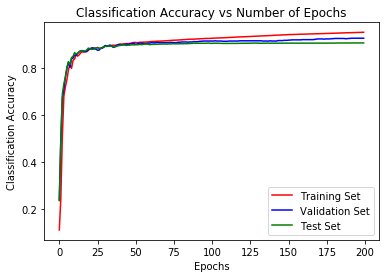

For this network with 1000 hidden nodes, the accuracies at the end of 200 Epochs are,

|   Dataset  | Accuracy |
|:----------:|:--------:|
|  Training  |  95.45%  |
| Validation |  92.90%  |
|   Testing  |  90.89%  |

**Cross Entropy Loss**

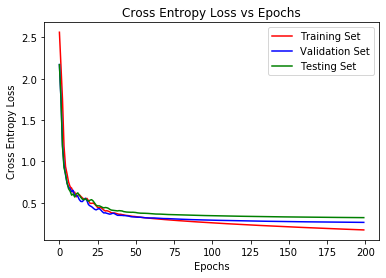

*Note: I noticed that at the learning rate of 1E-5, the solution often failed to converge. That is, after a few initial iterations, the loss would shoot up and never come down. As a result, the learning rate was lowered to 60% of 1E-5 to capture the outputs. No other aspect of the network was modified.*

## Hyperparameter investigation [3 points]

Continue to use $\alpha=0.9$ and $\eta=10^{-5}$.

Test your network with 500, 1500, 2500 hidden nodes and train for 200 epochs. Comment based on the validation accuracy after how many epochs training could be terminated early. 

Plot the training and validation accuracy curves for all three network sizes and 200 training epochs, and report the test accuracy for your selected network size and training length. Show the plot and the accuracies in the next markdown cell.

(Training of the large network for 200 epochs should take about 30-60 mins.)

Number of Hidden Units = 500


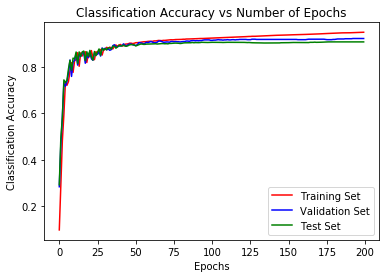

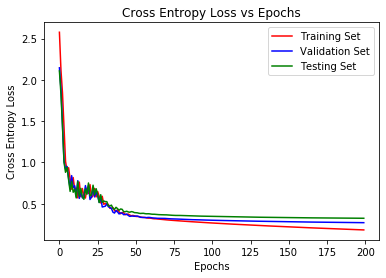

Number of Hidden Units = 1500


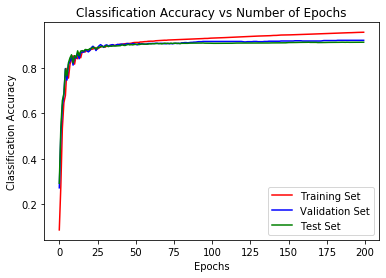

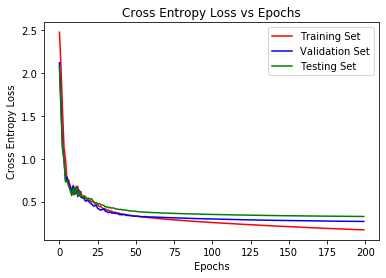

Number of Hidden Units = 2500


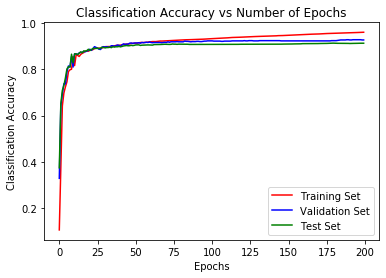

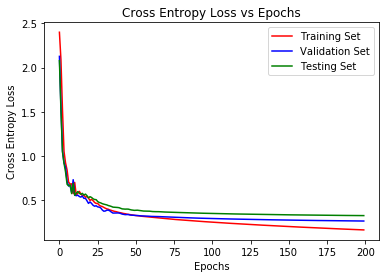

In [24]:
print('Number of Hidden Units = 500')
wHid500, wOp500, ltrain500, lvalid500, ltest500, atrain500, avalid500, atest500 = constructAndTrainNN(alpha,eta,numIter,500,numInputNodes,numOpNodes,centre,trainData,trainTargetOneHot,validData,validTargetOneHot,testData,testTargetOneHot)

print('Number of Hidden Units = 1500')
wHid1500, wOp1500, ltrain1500, lvalid1500, ltest1500, atrain1500, avalid1500, atest1500 = constructAndTrainNN(alpha,eta,numIter,1500,numInputNodes,numOpNodes,centre,trainData,trainTargetOneHot,validData,validTargetOneHot,testData,testTargetOneHot)

print('Number of Hidden Units = 2500')
wHid2500, wOp2500, ltrain2500, lvalid2500, ltest2500, atrain2500, avalid2500, atest2500 = constructAndTrainNN(alpha,eta,numIter,2500,numInputNodes,numOpNodes,centre,trainData,trainTargetOneHot,validData,validTargetOneHot,testData,testTargetOneHot)

**Solution:**

**Number of Hidden Units = 500**

Accuracy Curves

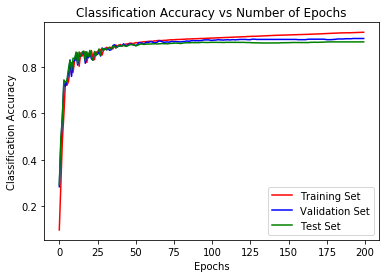

**Number of Hidden Units = 1500**

Accuracy Curves

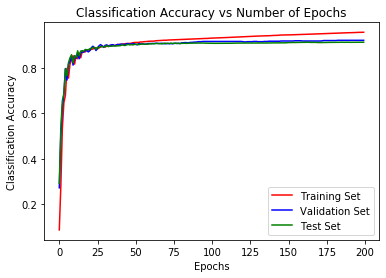

**Number of Hidden Units = 2500**

Accuracy Curves

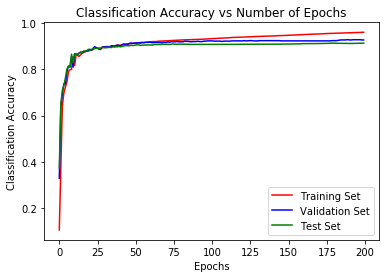

**Summary of Accuracies**

|              |       |              |    Accuracy    |             |
|:------------:|:-----:|:------------:|:--------------:|:-----------:|
| Hidden Units | Epoch | Training Set | Validation Set | Testing Set |
|      500     |  200  |    95.11%    |     92.40%     |    90.93%   |
|     1500     |  200  |    95.65%    |     92.10%     |    91.26%   |
|     2500     |  200  |    95.93%    |     92.60%     |    91.18%   |

With respect to the validation accuracies, the highest validation accuracies were achieved at the following epochs for the each network.

| Hidden Units | Epoch Count at Highest Validation Accuracy |
|:------------:|:------------------------------------------:|
|      500     |                     193                    |
|     1500     |                     183                    |
|     2500     |                     189                    |

Accuracies at the corresponding epochs have been tabulated below.

|              |       |              |    Accuracy    |             |
|:------------:|:-----:|:------------:|:--------------:|:-----------:|
| Hidden Units | Epoch | Training Set | Validation Set | Testing Set |
|      500     |  193  |    94.95%    |     92.40%     |    90.97%   |
|     1500     |  183  |    95.27%    |     92.10%     |    91.19%   |
|     2500     |  189  |    95.66%    |     92.70%     |    91.12%   |